In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import polars as pl
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pickle
import os
import sqlite3

In [3]:
df = pl.read_parquet('enc2_fast_cat_price.parquet')

df = df.with_columns(
    pl.col('visits').fill_null(0),
    pl.col('adds').fill_null(0),
    pl.col('rms').fill_null(0),
    pl.col('searchs').fill_null(0),
    pl.col('buys').fill_null(0),
    pl.col('kde_visits').fill_null([0] * 11),
    pl.col('kde_adds').fill_null([0] * 11),
    pl.col('kde_rms').fill_null([0] * 11),
    pl.col('kde_searchs').fill_null([0] * 11),
    pl.col('kde_buys').fill_null([0] * 11),
    pl.col('url_visit').fill_null([]),
    pl.col('sku_add').fill_null([]),
    pl.col('sku_rm').fill_null([]),
    pl.col('query_search').fill_null([0] * 64),
    pl.col('sku_buy').fill_null([]),
    pl.col('sku_add_cat').fill_null([]),
    pl.col('sku_rm_cat').fill_null([]),
    pl.col('sku_buy_cat').fill_null([]),
    pl.col('sku_add_price').fill_null([]),
    pl.col('sku_rm_price').fill_null([]),
    pl.col('sku_buy_price').fill_null([])
)

In [4]:
df = df.with_columns(pl.col('sku_buy_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_buy'),
                    pl.col('sku_rm_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_rm'),
                    pl.col('sku_add_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_add'))

In [5]:
points = np.arange(11) / 10
masses = {}
for c in ['kde_buys', 'kde_visits', 'kde_adds', 'kde_rms', 'kde_searchs']:
    alias = 'mass_' + c.split('_')[1]
    density = np.asarray(df[c].to_list())
    mass = np.sum(density * points, axis=1) / np.clip(np.sum(density, axis=1), a_min=1e-8, a_max=None)
    masses[alias] = mass

df_mass = pl.DataFrame(data=masses)

df = pl.concat([df, df_mass], how='horizontal')

In [6]:
df.describe()

statistic,client_id,visits,adds,rms,searchs,buys,kde_visits,kde_adds,kde_rms,kde_searchs,kde_buys,url_visit,sku_add,sku_rm,query_search,sku_buy,sku_add_cat,sku_rm_cat,sku_buy_cat,sku_add_price,sku_rm_price,sku_buy_price,price_buy,price_rm,price_add,mass_buys,mass_visits,mass_adds,mass_rms,mass_searchs
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",499999.5,36.763237,2.707519,1.148122,4.46087,1.096716,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,29.047337,15.769935,31.259434,0.263441,0.458623,0.298378,0.160259,0.193171
"""std""",288675.278932,116.908754,9.765367,6.043549,20.112477,2.889363,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,33.110316,28.362211,33.331405,0.3203,0.30092,0.330088,0.288542,0.307538
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",250000.0,2.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.194966,0.0,0.0,0.0
"""50%""",500000.0,11.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,9.0,0.0,22.166667,0.068849,0.480763,0.153164,0.0,0.0
"""75%""",749999.0,34.0,2.0,1.0,2.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,60.0,23.0,61.0,0.532166,0.718896,0.597072,0.19811,0.375758
"""max""",9.99999e5,29676.0,1597.0,1145.0,3384.0,644.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,99.0,99.0,99.0,0.94799,0.94799,0.947987,0.947985,0.947988


In [7]:
clients = np.load('data/input/relevant_clients.npy')
buys = pl.read_parquet('data/product_buy.parquet')

In [8]:
buys = buys.filter(pl.col('client_id').is_in(set(clients)))

In [9]:
df.filter(pl.col('buys') > 0).describe()

statistic,client_id,visits,adds,rms,searchs,buys,kde_visits,kde_adds,kde_rms,kde_searchs,kde_buys,url_visit,sku_add,sku_rm,query_search,sku_buy,sku_add_cat,sku_rm_cat,sku_buy_cat,sku_add_price,sku_rm_price,sku_buy_price,price_buy,price_rm,price_add,mass_buys,mass_visits,mass_adds,mass_rms,mass_searchs
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0,510971.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",499889.265857,50.143593,3.895321,1.653626,6.231007,2.146337,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,56.847329,18.016703,36.994913,0.515569,0.399931,0.359835,0.191306,0.213084
"""std""",288606.515506,145.039547,12.821275,8.002104,25.832602,3.753066,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,23.772945,29.389455,32.778649,0.266061,0.318315,0.330652,0.307445,0.318119
"""min""",1.0,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.052014,0.0,0.0,0.0,0.0
"""25%""",249976.0,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,39.0,0.0,0.0,0.283735,0.0,0.0,0.0,0.0
"""50%""",499265.0,17.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,59.0,0.0,37.5,0.524185,0.4246,0.333922,0.0,0.0
"""75%""",749780.0,49.0,3.0,1.0,3.0,2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,76.0,34.0,66.0,0.746678,0.679975,0.662614,0.380899,0.4672
"""max""",999995.0,29676.0,1597.0,1145.0,3384.0,644.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,99.0,99.0,99.0,0.94799,0.947938,0.947958,0.947938,0.947978


In [10]:
embs = np.load('analysis/full.npy')

In [11]:
df_embs = pl.from_numpy(embs, schema=['x', 'y'])

In [12]:
df_full = pl.concat([df, df_embs], how="horizontal")

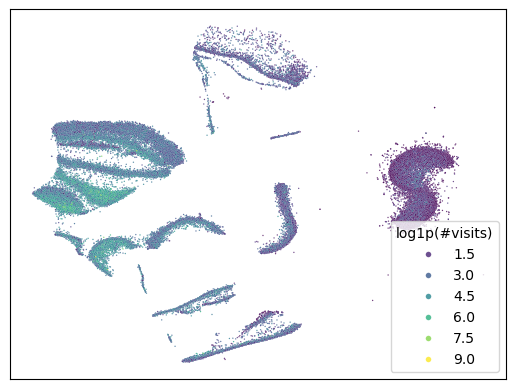

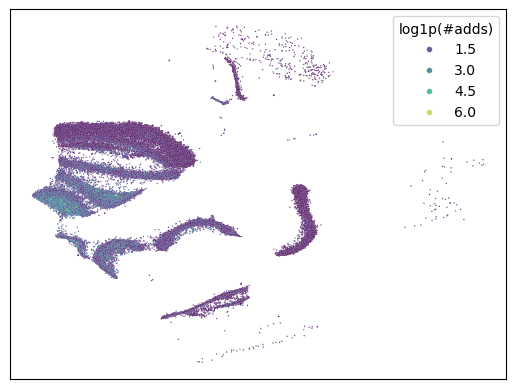

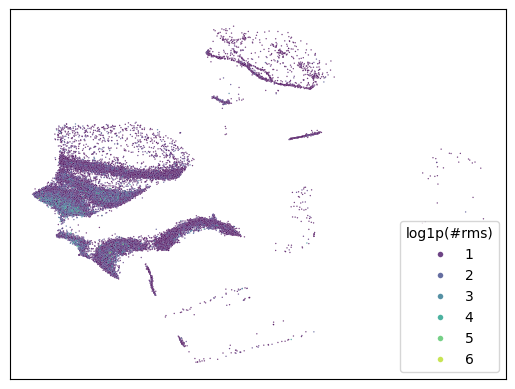

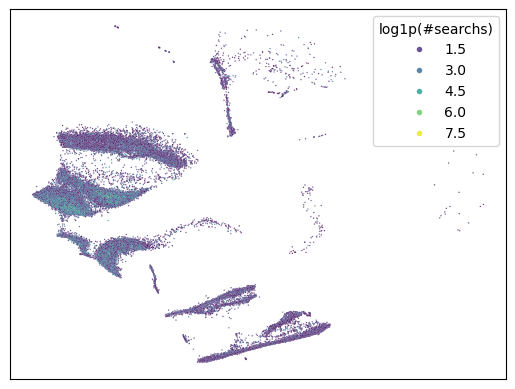

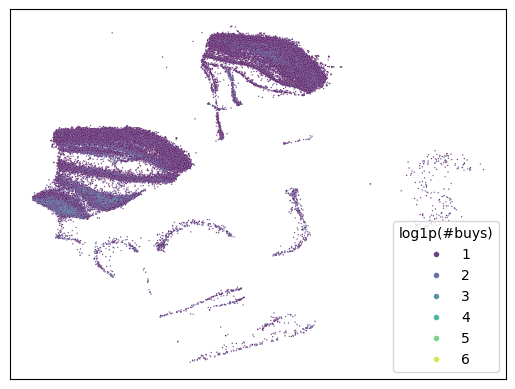

In [13]:
for c in ['visits', 'adds', 'rms', 'searchs', 'buys']:
    df_plot = df_full.filter(pl.col(c) > 0).to_pandas().sample(100000, random_state=42).copy()
    df_plot[f'log_{c}'] = np.log1p(df_plot[c])
    
    scatter = sns.scatterplot(
        data=df_plot,
        x='x', y='y',
        hue=f'log_{c}',
        palette='viridis',  # o 'magma', 'plasma', etc.
        s=1,
        alpha=0.8  # un poco de transparencia para evitar saturación
    )
    scatter.set_ylabel('')
    scatter.set_xlabel('')
    scatter.set_yticks([])
    scatter.set_xticks([])
    
    #plt.legend(title=f'log1p({c})')
    handles, labels = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, labels=labels, title=f'log1p(#{c})', scatterpoints=1, markerscale=4)
    plt.savefig(f"embs_{c}.pdf")
    plt.show()

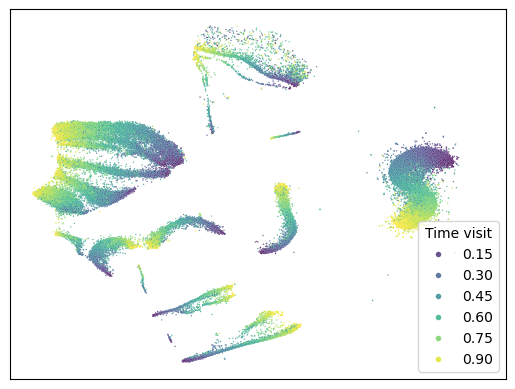

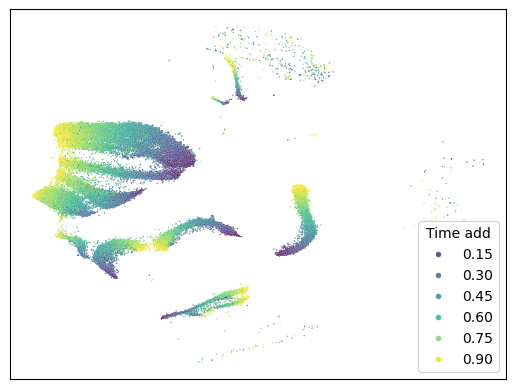

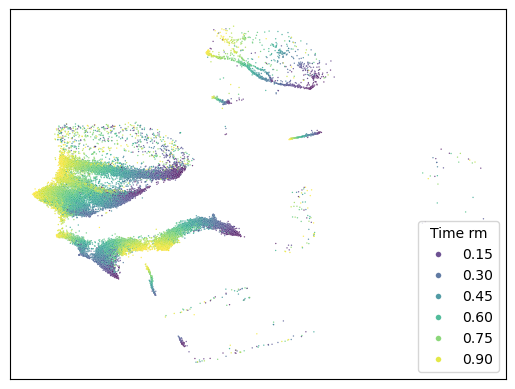

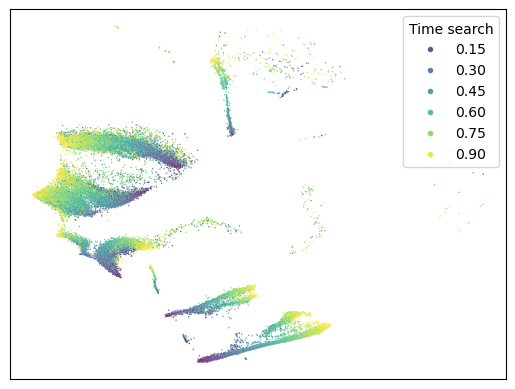

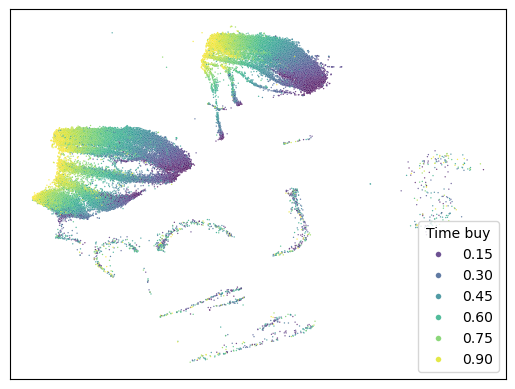

In [14]:
for c in ['visits', 'adds', 'rms', 'searchs', 'buys']:
    df_plot = df_full.filter(pl.col(c) > 0).to_pandas()
    if len(df_plot) > 100000:
        df_plot = df_plot.sample(100000, random_state=42).copy()
        
    scatter = sns.scatterplot(
        data=df_plot,
        x='x', y='y',
        hue=f'mass_{c}',
        palette='viridis',  # o 'magma', 'plasma', etc.
        s=1,
        alpha=0.8  # un poco de transparencia para evitar saturación
    )
    scatter.set_ylabel('')
    scatter.set_xlabel('')
    scatter.set_yticks([])
    scatter.set_xticks([])
    #plt.legend(title=f'log1p({c})')
    handles, labels = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, labels=labels, title=f'Time {c[:-1]}', scatterpoints=1, markerscale=4)
    plt.savefig(f"embs_time_{c}.pdf")
    plt.show()